In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
content_path = 'images/swan.jpg'
style_path = 'images/painting.jpg'

In [3]:
def load_image(path):
    """
    
    """
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

In [4]:
content_image = load_image(content_path)

In [5]:
tf.shape(content_image)

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 732, 1280,    3], dtype=int32)>

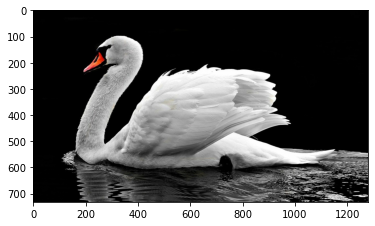

In [6]:

plt.imshow(load_image(content_path))

In [7]:
def load_image_scale(path):
    maximum_dim = 512
    
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    shape = tf.shape(image)
    size_without_channel = shape[:-1]
    size_without_channel = tf.cast(size_without_channel, tf.float32)
    
    max_dim = max(size_without_channel)
    scale = maximum_dim / max_dim
    
    size_without_channel = size_without_channel * scale
    size_without_channel = tf.cast(size_without_channel, tf.int32)
    
    image = tf.image.resize(image, size_without_channel)
    image = image[tf.newaxis, :]
    
    image = tf.image.convert_image_dtype(image, tf.uint8)
    return image

In [8]:
def load_images(content_path, 
                style_path):
    content_image = load_image_scale(content_path)
    style_image = load_image_scale(style_path)
    return content_image, style_image


In [9]:
content_image, style_image = load_images(content_path,
                                       style_path)

In [10]:
def show_images_with_objects(images, titles=[]):
    
    assert len(images) == len(titles), 'make sure you have same number of \
                                       titles and images'

    plt.figure(figsize=(20, 12))
    for idx, (image, title) in enumerate(zip(images,
                                          titles)):
        plt.subplot(1,len(images), idx + 1)
        if len(image.shape) > 3:
            image = tf.squeeze(image, axis=0)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.title(title)


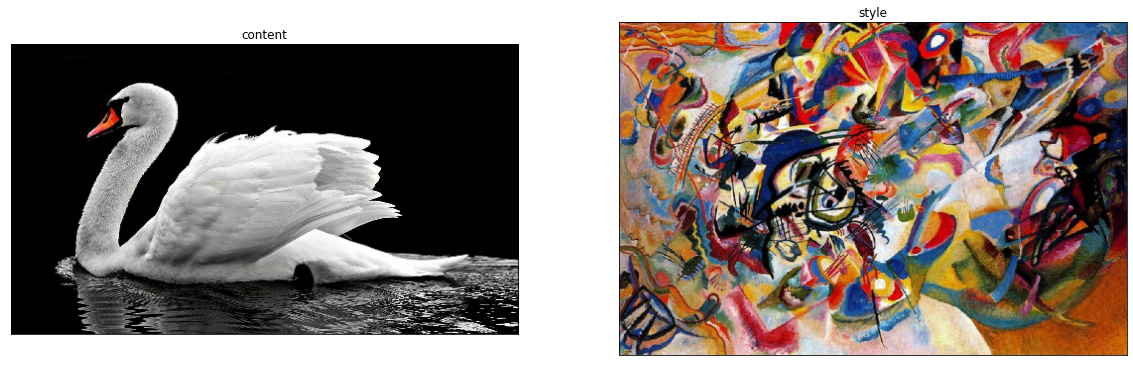

In [11]:
show_images_with_objects(images=[content_image, style_image], titles=['content', 'style'])

In [12]:
from keras import backend as K

In [13]:
K.clear_session()

In [14]:
# style layers of interest
style_layers = ['block1_conv1', 
                'block2_conv1', 
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'] 

# choose the content layer and put in a list
content_layers = ['block5_conv2'] 

# combine the two lists (put the style layers before the content layers)
output_layers = style_layers + content_layers 

# declare auxiliary variables holding the number of style and content layers
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

In [15]:
def vgg_model(layer_names):
  """ Creates a vgg model that outputs the style and content layer activations.
  
  Args:
    layer_names: a list of strings, representing the names of the desired content and style layers
    
  Returns:
    A model that takes the regular vgg19 input and outputs just the content and style layers.
  
  """

  # load the the pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

  # freeze the weights of the model's layers (make them not trainable)
  vgg.trainable = False
  
  # create a list of layer objects that are specified by layer_names
  outputs = [vgg.get_layer(name).output for name in layer_names]

  # create the model that outputs content and style layers only
  model = tf.keras.Model(inputs=vgg.input, outputs=outputs)

  return model

In [32]:
K.clear_session()
# create a vgg-19 model
vgg = vgg_model(output_layers)
vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [33]:
def gram_matrix(layer_output):
    """
    """
    gram = tf.linalg.einsum('bijc, bijd -> bcd',
                            layer_output,
                            layer_output)
    
    height, width = tf.shape(layer_output)[1], tf.shape(layer_output)[2]
    position = tf.cast(height * width, tf.float32)
    scaled_gram = gram / position
    return scaled_gram

In [34]:
epochs = 10
steps_per_epoch = 100
optimizer = tf.optimizers.Adam(tf.keras.optimizers.schedules.ExponentialDecay(
                                    initial_learning_rate=30.0,
                                    decay_steps=100,
                                    decay_rate=0.80))

In [35]:
optimizer = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=30.0, decay_steps=100, decay_rate=0.80
    )
)

In [36]:
style_weight =  1e-4
content_weight = 1e-32 

In [37]:
from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

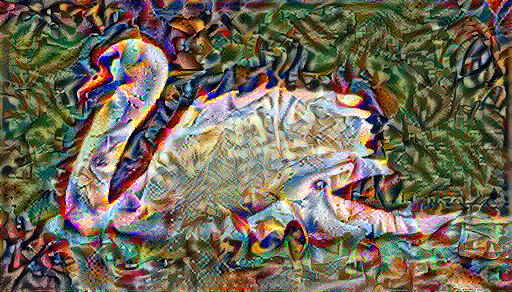

Train step: 100
...............................................................

KeyboardInterrupt: 

In [22]:
images = [] 
step = 0
#style_targets = get_style_image_features(style_image)
style_image = tf.cast(style_image, tf.float32)
style_image = tf.keras.applications.vgg19.preprocess_input(style_image)

outputs = vgg(style_image)

style_outputs = outputs[:NUM_STYLE_LAYERS]
gram_style_features = [gram_matrix(i) for i in style_outputs]

style_targets = gram_style_features

#  content_targets = get_content_image_features(content_image)


content_image_preprocess = tf.keras.applications.vgg19.preprocess_input(tf.cast(content_image,
                                 tf.float32))
content_outputs = vgg(content_image_preprocess) 
content_outputs_features = content_outputs[NUM_STYLE_LAYERS:]

content_targets = content_outputs_features


generated_image = tf.cast(content_image, tf.float32)
generated_image = tf.Variable(generated_image)
images.append(content_image)


# incrementally update the content image with style features

for n in range(epochs):
    for m in range(steps_per_epoch):
        step +=1
        
        # Update the image with the style using the function that you defined
        #update_image_with_style(generated_image, style_targets, content_targets, 
                              #style_weight, content_weight, var_weight, optimizer) 
        # calculate gradients using the function that you just defined.
        
        #gradients = calculate_gradients(image, style_targets, content_targets, 
                                 # style_weight, content_weight, var_weight) 
        with tf.GradientTape() as tape:
            style_features = vgg(tf.keras.applications.vgg19.preprocess_input(
                                                                          tf.cast(generated_image, 
                                                                                  tf.float32)))[:NUM_STYLE_LAYERS]
            style_features =  [gram_matrix(style_layer) for style_layer in style_features]
            
            
            content_features = vgg(tf.keras.applications.vgg19.preprocess_input(
                                                                          tf.cast(generated_image, tf.float32)))[NUM_STYLE_LAYERS:]
        
        
            style_loss = tf.add_n([tf.reduce_mean(tf.square(style_feature - style_target)) for style_feature, style_target in zip(style_features, style_targets)]) 
            content_loss = tf.add_n([0.5 * tf.reduce_mean(tf.square(content_feature - content_target)) for content_feature, content_target in zip(content_features, content_targets)]) 

            style_loss = style_loss * style_weight / NUM_STYLE_LAYERS
            content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS
            loss = content_loss + style_loss
        
         
                
                
                
                
        gradients = tape.gradient(loss, generated_image)

        optimizer.apply_gradients([(gradients,
                                    generated_image)])
        generated_image.assign(tf.clip_by_value(generated_image,
                                               clip_value_min=0.0,
                                               clip_value_max=255.0))
            
        print('.', end='')
        if (m + 1) % 10 == 0:
            images.append(generated_image)
        
    clear_output(wait=True)
    # display_image = tensor_to_image(generated_image)
    
    tensor_shape = tf.shape(generated_image)
    number_elem_shape = tf.shape(tensor_shape)
    if number_elem_shape > 3:
       assert tensor_shape[0] == 1
       tensor = generated_image[0]
    display_image = tf.keras.preprocessing.image.array_to_img(tensor) 

    
    display_fn(display_image)
    images.append(generated_image)
    print("Train step: {}".format(step))
generated_image = tf.cast(generated_image, dtype=tf.uint8)
        
        

In [38]:
style_weight =  1e-4
content_weight = 1e-32
var_weight = 1e-2


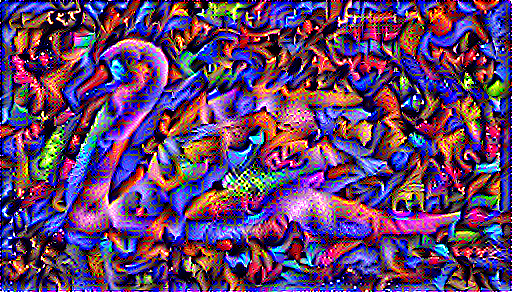

Train step: 1000


In [39]:
images = [] 
step = 0
#style_targets = get_style_image_features(style_image)
style_image = tf.cast(style_image, tf.float32)
style_image = tf.keras.applications.vgg19.preprocess_input(style_image)

outputs = vgg(style_image)

style_outputs = outputs[:NUM_STYLE_LAYERS]
gram_style_features = [gram_matrix(i) for i in style_outputs]

style_targets = gram_style_features

#  content_targets = get_content_image_features(content_image)


content_image_preprocess = tf.keras.applications.vgg19.preprocess_input(tf.cast(content_image,
                                 tf.float32))
content_outputs = vgg(content_image_preprocess) 
content_outputs_features = content_outputs[NUM_STYLE_LAYERS:]

content_targets = content_outputs_features


generated_image = tf.cast(content_image, tf.float32)
generated_image = tf.Variable(generated_image)
images.append(content_image)


# incrementally update the content image with style features

for n in range(epochs):
    for m in range(steps_per_epoch):
        step +=1
        
        # Update the image with the style using the function that you defined
        #update_image_with_style(generated_image, style_targets, content_targets, 
                              #style_weight, content_weight, var_weight, optimizer) 
        # calculate gradients using the function that you just defined.
        
        #gradients = calculate_gradients(image, style_targets, content_targets, 
                                 # style_weight, content_weight, var_weight) 
        with tf.GradientTape() as tape:
            style_features = vgg(tf.keras.applications.vgg19.preprocess_input(
                                                                          tf.cast(generated_image, 
                                                                                  tf.float32)))[:NUM_STYLE_LAYERS]
            style_features =  [gram_matrix(style_layer) for style_layer in style_features]
            
            
            content_features = vgg(tf.keras.applications.vgg19.preprocess_input(
                                                                          tf.cast(generated_image, tf.float32)))[NUM_STYLE_LAYERS:]
        
        
            style_loss = tf.add_n([tf.reduce_mean(tf.square(style_feature - style_target)) for style_feature, style_target in zip(style_features, style_targets)]) 
            content_loss = tf.add_n([0.5 * tf.reduce_mean(tf.square(content_feature - content_target)) for content_feature, content_target in zip(content_features, content_targets)]) 

            style_loss = style_loss * style_weight / NUM_STYLE_LAYERS
            content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS
            loss = content_loss + style_loss
            loss += var_weight * tf.image.total_variation(generated_image)
        
         
                
                
                
                
        gradients = tape.gradient(loss, generated_image)

        optimizer.apply_gradients([(gradients,
                                    generated_image)])
        generated_image.assign(tf.clip_by_value(generated_image,
                                               clip_value_min=0.0,
                                               clip_value_max=255.0))
            
        print('.', end='')
        if (m + 1) % 10 == 0:
            images.append(generated_image)
        
    clear_output(wait=True)
    # display_image = tensor_to_image(generated_image)
    
    tensor_shape = tf.shape(generated_image)
    number_elem_shape = tf.shape(tensor_shape)
    if number_elem_shape > 3:
       assert tensor_shape[0] == 1
       tensor = generated_image[0]
    display_image = tf.keras.preprocessing.image.array_to_img(tensor) 

    
    display_fn(display_image)
    images.append(generated_image)
    print("Train step: {}".format(step))
generated_image = tf.cast(generated_image, dtype=tf.uint8)
        
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


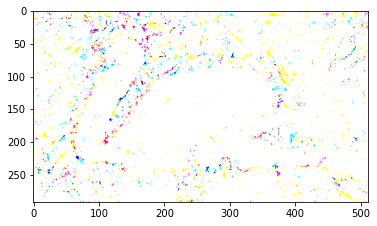

In [44]:

plt.imshow(images[4][0]);

In [32]:
from imageio import mimsave

In [50]:
def create_gif(GIF_PATH,
               images):
    gif_path = mimsave(GIF_PATH, images, fps=1)
    with open(GIF_PATH, 'rb') as f:
        display_fn(Image(data=f.read(), format='png'))
    


In [41]:
import numpy as np

In [42]:
from IPython.display import Image, clear_output

In [43]:
GIF_PATH='style_transfer_regularization.gif'
gif_images = [np.squeeze(image.numpy().astype(np.uint8), axis=0) for image in images]

In [44]:
def display_gif(gif_path):
  '''displays the generated images as an animated gif'''
  with open(gif_path,'rb') as f:
    display_fn(Image(data=f.read(), format='png'))


def create_gif(gif_path, images):
  '''creates animation of generated images'''
  mimsave(gif_path, images, fps=1)
  
  return gif_path

In [46]:
create_gif(GIF_PATH, gif_images)

'style_transfer_regularization.gif'

In [52]:
content_image, style_image = load_images(content_path,
                                       style_path)

In [53]:
content_image.shape

TensorShape([1, 292, 512, 3])

In [47]:

content_image = tf.image.convert_image_dtype(content_image, tf.float32)

In [48]:
content_image.shape

TensorShape([1, 292, 512, 3])

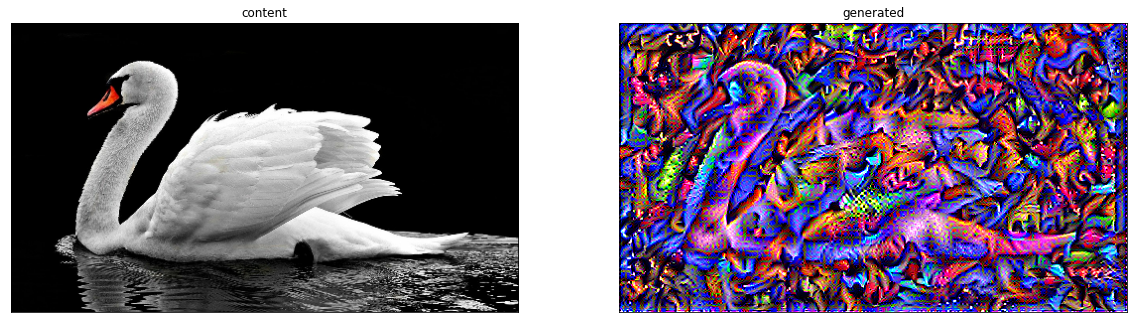

In [49]:
show_images_with_objects([content_image, generated_image], ['content', 'generated'])

In [50]:
def high_pass_x_y(image_):
    image_ = tf.image.convert_image_dtype(image_, tf.float32)
    y_var = image_[:, 1:, :,:] - image_[:, :-1, :,:]
    x_var = image_[:, :, 1:, :] - image_[:,:, :-1,:]
    

    return x_var, y_var

In [51]:
content_image, style_image = load_images(content_path,
                                       style_path)

In [52]:
x_var_content, y_var_content = high_pass_x_y(content_image)
x_var_generated, y_var_generated = high_pass_x_y(generated_image)

In [53]:
x_var_content.shape

TensorShape([1, 292, 511, 3])

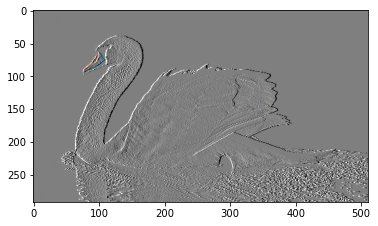

In [54]:
plt.imshow(tf.squeeze(tf.clip_by_value(x_var_content*2  + 0.5, clip_value_max=1.0, clip_value_min=0.0), axis=0))

In [55]:
def imshow(image, title=None):
  '''displays an image with a corresponding title'''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

In [56]:
def plot_delta(x_var, y_var, name='content'):
    plt.figure(figsize=(20,12))
    plt.subplot(1, 2, 1)
    x_var = tf.clip_by_value(2 * x_var + 0.5, 
                     clip_value_min=0.0, clip_value_max=1.0)
    y_var = tf.clip_by_value(2 * y_var + 0.5, 
                     clip_value_min=0.0, clip_value_max=1.0)
    plt.imshow(tf.squeeze(tf.clip_by_value(x_var_content*2  + 0.5, clip_value_max=1.0, clip_value_min=0.0), axis=0))
    plt.yticks([])
    plt.xticks([])
    plt.title('Vertical')
    
    plt.subplot(1, 2, 2)
    plt.imshow(tf.squeeze(tf.clip_by_value(y_var_content*2  + 0.5, clip_value_max=1.0, clip_value_min=0.0), axis=0))
    plt.yticks([])
    plt.xticks([])
    plt.title('Horizontal')
    
    

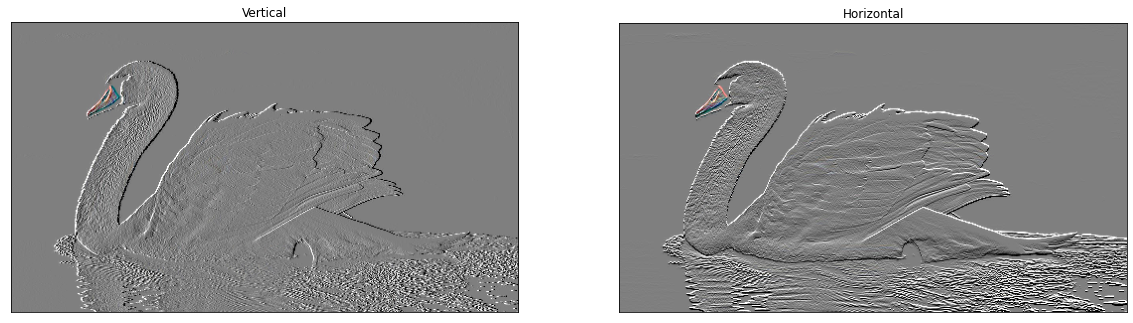

In [57]:
plot_delta(x_var_content, y_var_content)

In [58]:
def var_to_image(x_var, y_var):
    x_var = tf.clip_by_value(2 * x_var + 0.5, 
                     clip_value_min=0.0, clip_value_max=1.0)
    y_var = tf.clip_by_value(2 * y_var + 0.5, 
                     clip_value_min=0.0, clip_value_max=1.0)
    im_x = tf.squeeze(x_var, axis=0)
    im_y = tf.squeeze(y_var, axis=0)
    return im_x, im_y

In [59]:
def plot_delta_with_generated_image(x_var, y_var,x_gen, y_gen, name='content'):
    plt.figure(figsize=(20,12))
    plt.subplot(2, 2, 1)
    im_x, im_y = var_to_image(x_var, y_var)
    plt.imshow(im_x)
    plt.yticks([])
    plt.xticks([])
    plt.title('Vertical')
    
    plt.subplot(2, 2, 3)
    plt.imshow(im_y)
    plt.yticks([])
    plt.xticks([])
    plt.title('Horizontal')
    
    im_x_gen, im_y_gen = var_to_image(x_gen, y_gen)
    plt.subplot(2, 2, 2)
    plt.imshow(im_x_gen)
    plt.yticks([])
    plt.xticks([])
    plt.title('Vertical')
    
    plt.subplot(2, 2, 4)
    plt.imshow(im_x_gen)
    plt.yticks([])
    plt.xticks([])
    plt.title('Horizontal')

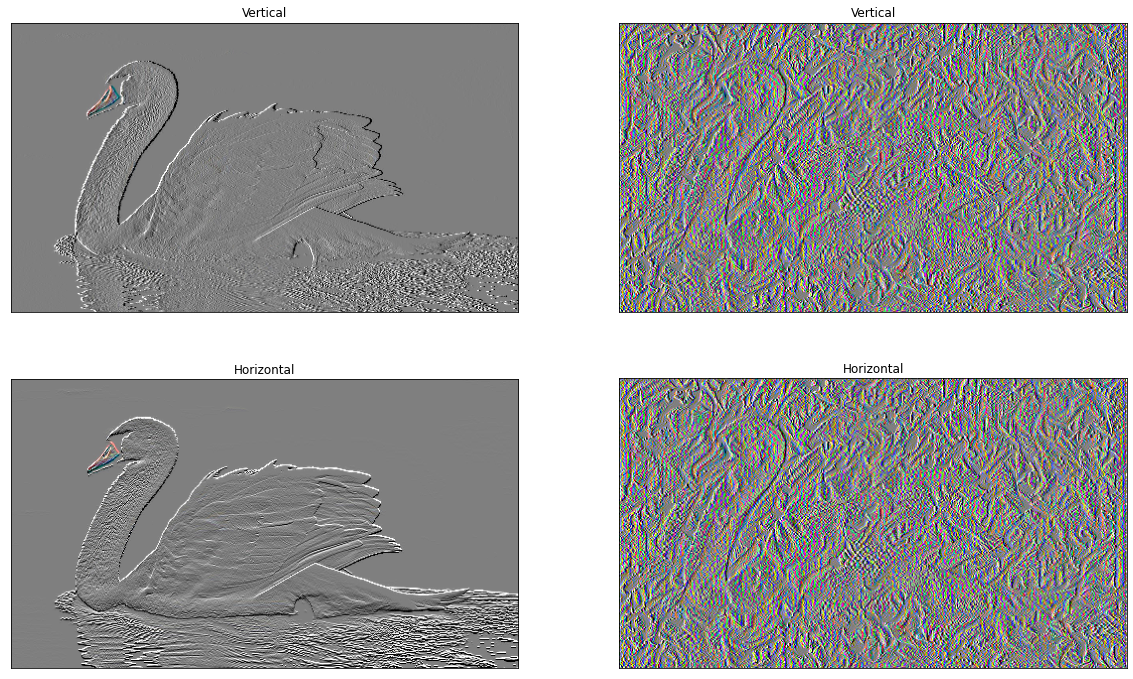

In [60]:
plot_delta_with_generated_image(x_var_content, y_var_content,x_var_generated, y_var_generated)

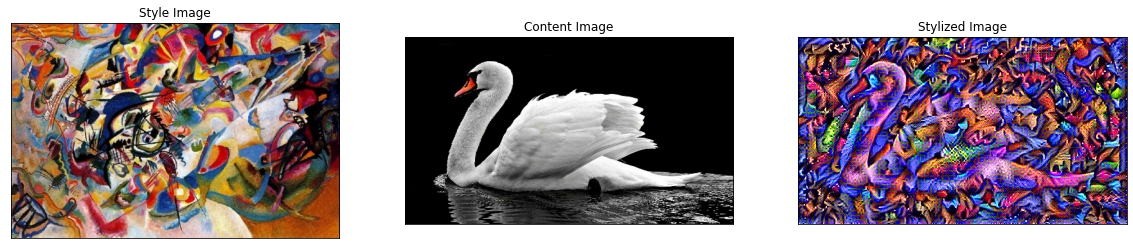

In [61]:
show_images_with_objects([style_image, content_image, generated_image], titles=['Style Image', 'Content Image', 'Stylized Image'])